# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [10]:
import numpy as np
import itertools
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* http://suanlab.com/datasets/GeneralMidi.wav



In [11]:
!wget http://suanlab.com/datasets/GeneralMidi.wav

--2024-11-04 08:50:30--  http://suanlab.com/datasets/GeneralMidi.wav
Resolving suanlab.com (suanlab.com)... 52.219.144.88, 52.219.56.124, 3.5.188.50, ...
Connecting to suanlab.com (suanlab.com)|52.219.144.88|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3409459756 (3.2G) [audio/wav]
Saving to: ‘GeneralMidi.wav’

GeneralMidi.wav     100%[===================>]   3.17G  27.2MB/s    in 97s     

2024-11-04 08:52:07 (33.7 MB/s) - ‘GeneralMidi.wav’ saved [3409459756/3409459756]



In [12]:
midi_file ="./GeneralMidi.wav"

* wmv 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [13]:
instruments = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
num_notes = 50
sec = 2

audio = []
inst = []
for inst_idx, note in itertools.product(range(len(instruments)), range(50)):
  instrument = instruments[inst_idx]
  offset = (instrument * num_notes * sec) +(note * sec)
  print('instrument: {}, note: {}, offset: {}'.format(instrument, note, offset))
  y, sr = librosa.load(midi_file, sr = None, offset=offset, duration=2.0)
  audio.append(y)
  inst.append(inst_idx)


instrument: 0, note: 0, offset: 0
instrument: 0, note: 1, offset: 2
instrument: 0, note: 2, offset: 4
instrument: 0, note: 3, offset: 6
instrument: 0, note: 4, offset: 8
instrument: 0, note: 5, offset: 10
instrument: 0, note: 6, offset: 12
instrument: 0, note: 7, offset: 14
instrument: 0, note: 8, offset: 16
instrument: 0, note: 9, offset: 18
instrument: 0, note: 10, offset: 20
instrument: 0, note: 11, offset: 22
instrument: 0, note: 12, offset: 24
instrument: 0, note: 13, offset: 26
instrument: 0, note: 14, offset: 28
instrument: 0, note: 15, offset: 30
instrument: 0, note: 16, offset: 32
instrument: 0, note: 17, offset: 34
instrument: 0, note: 18, offset: 36
instrument: 0, note: 19, offset: 38
instrument: 0, note: 20, offset: 40
instrument: 0, note: 21, offset: 42
instrument: 0, note: 22, offset: 44
instrument: 0, note: 23, offset: 46
instrument: 0, note: 24, offset: 48
instrument: 0, note: 25, offset: 50
instrument: 0, note: 26, offset: 52
instrument: 0, note: 27, offset: 54
instrum

In [14]:
import numpy as np

audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)

print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


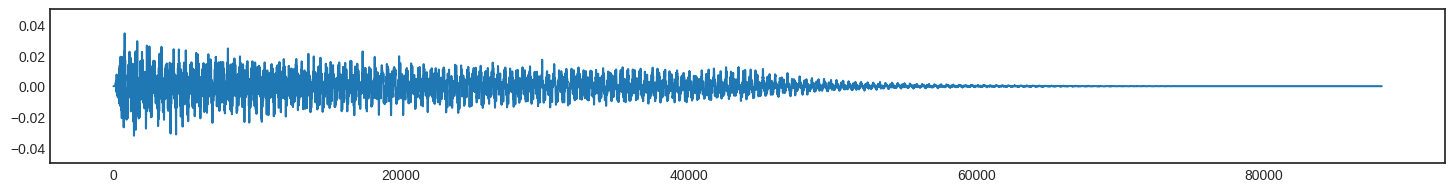

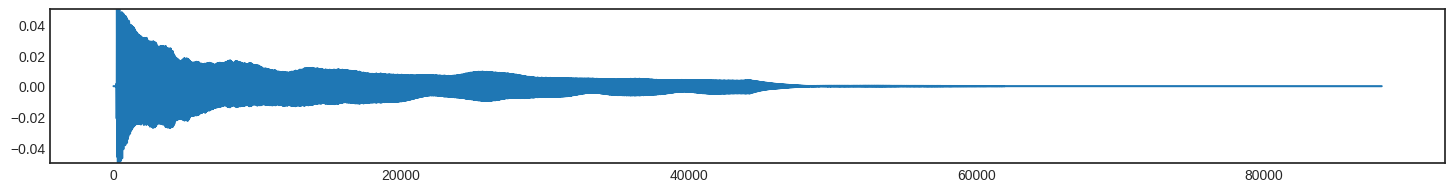

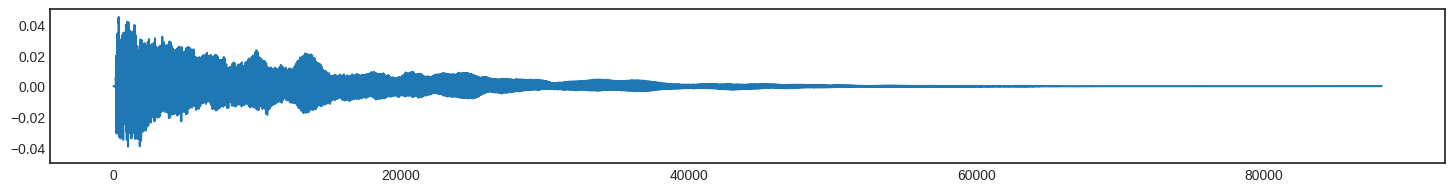

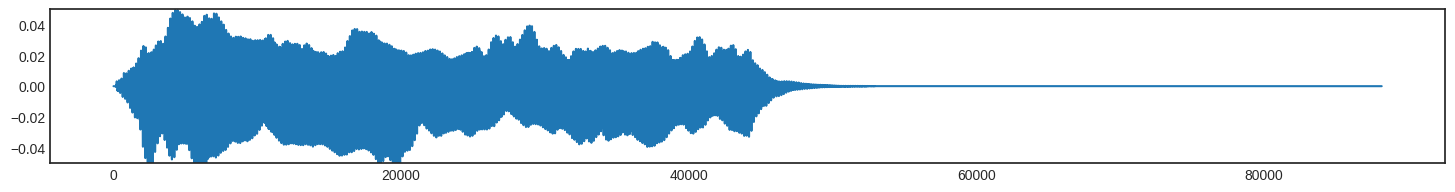

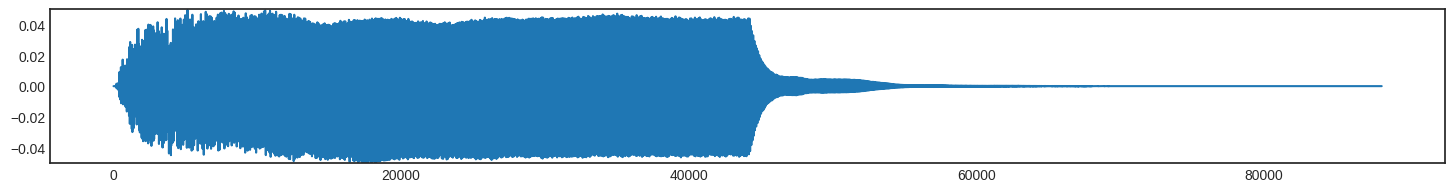

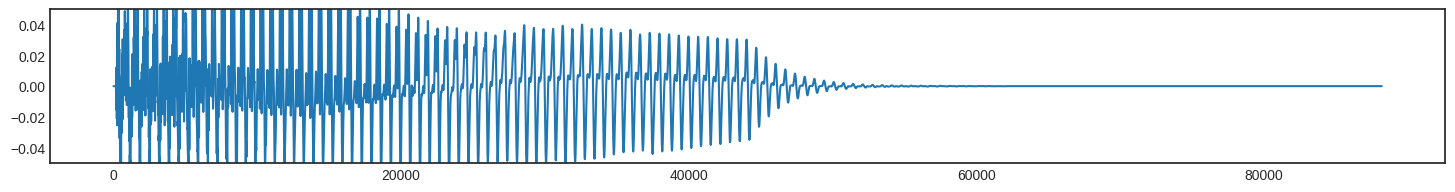

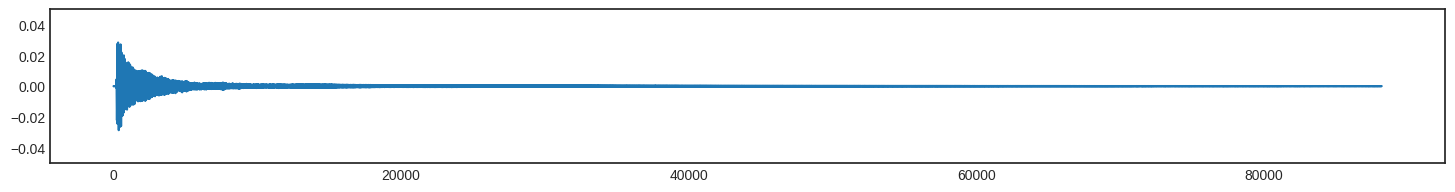

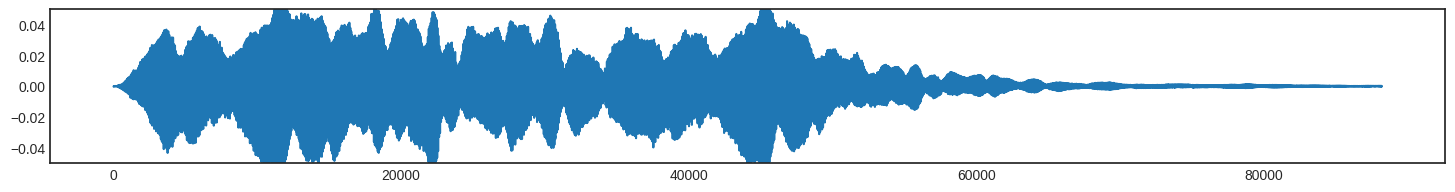

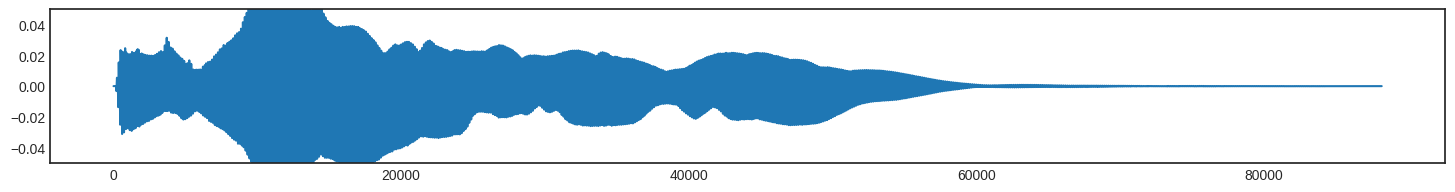

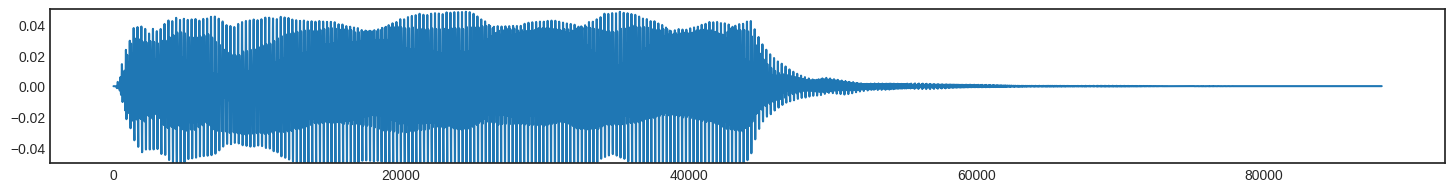

In [15]:
for idx in range(0, len(audio_np), num_notes):
  plt.figure(figsize=(18,2))
  plt.plot(audio_np[idx])
  plt.ylim(-0.05, 0.05)
  plt.show()

In [16]:
print(inst_np[0])

ipd.Audio(audio_np[0], rate=sr)

0


In [17]:
print(inst_np[50])

ipd.Audio(audio_np[50], rate=sr)

1


In [18]:
print(inst_np[100])

ipd.Audio(audio_np[100], rate=sr)

2


In [19]:
print(inst_np[150])

ipd.Audio(audio_np[150], rate=sr)

3


In [20]:
print(inst_np[200])

ipd.Audio(audio_np[200], rate=sr)

4


In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(audio_np)

MinMaxScaler()

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [22]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(400, 88200)
(100, 88200)
(400,)
(100,)


### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.07


### Support Vector Machine

In [24]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)


0.07


### Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.39


오디오 데이터의 특징상 데이터 길이가 길고, 많아서 처리를 잘못하는 것으로 예상

## Constant-Q를 이용한 머신러닝 오디오 분류

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음
* 푸리에 변환 대신 푸리에 변환과 유사한 Constant-Q 변환을 사용
* Constant-Q 변환은 주파수 축이 로그 단위로 변환되고, 각 주파수에 따라 해상도가 다양하게 처리되기 때문에(저주파는 저해상도, 고주파는 고해상도) 음악을 처리하는 데에 푸리에 변환보다 유리

*   주파수 대역을 저장할 리스트 `audio_cqt` 선언
*   constant-Q 변환할 때는 변환할 오디오 데이터와 sampling rate가 필요
*   해당 데이터에서는 sampling rate가 모두 동일하므로 따로 처리가 필요하지 않음
*   여기서는 Constant-Q 변환을 사용해 오디오 데이터를 주파수 대역으로 변환




*   변환에는 앞서 준비한 데이터를 가져와 사용하며, Constant-Q 변환에는 `librosa.cqt` 함수를 사용
*   여기서 `n_bins`는 옥타브 단계 및 개수를, `bins_per_octave`는 한 옥타브가 가지는 단계를 의미
*   라벨에 대해선 원 핫 인코딩을 적용



In [26]:
audio_cqt = []

for y in audio:
  ret = librosa.cqt(y, sr=sr, hop_length=1024, n_bins=24*7, bins_per_octave=24)
  ret = np.abs(ret)
  audio_cqt.append(ret)

* 앞서 생성한 주파수 대역을 spectrogram으로 시각화
* 악기 간 spectrogram을 비교해보면 차이가 존재함을 알 수 있음

<ipython-input-27-ed14af4739b0>:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')


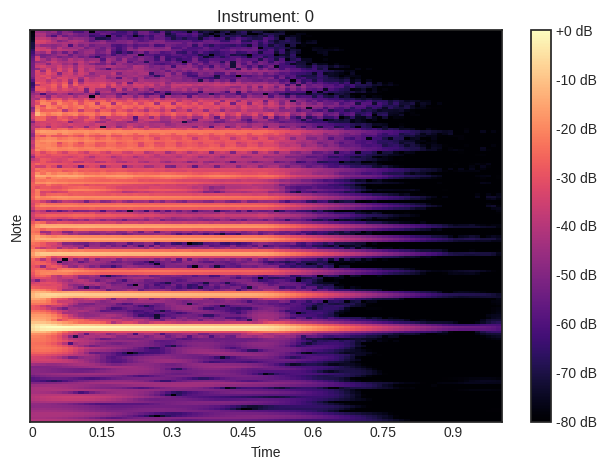

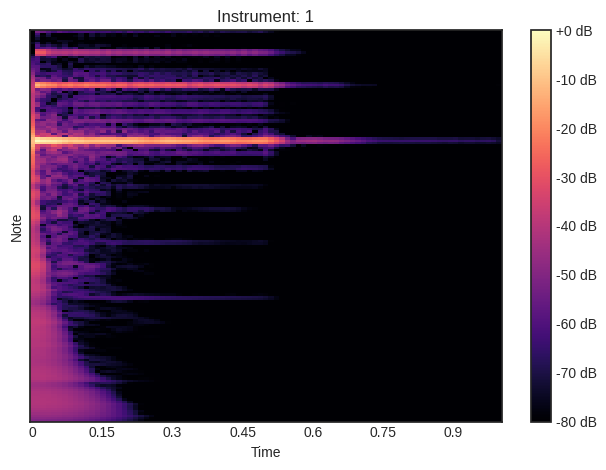

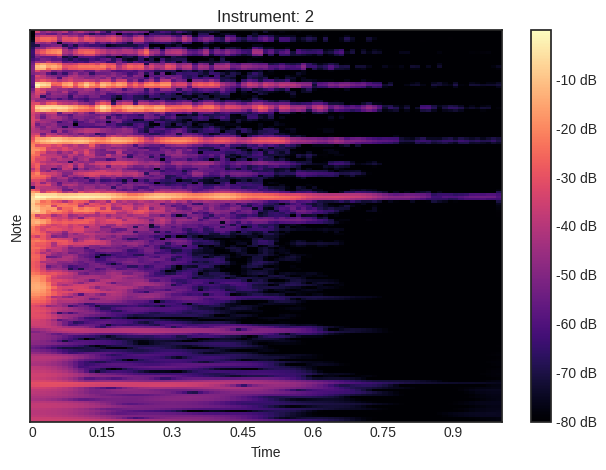

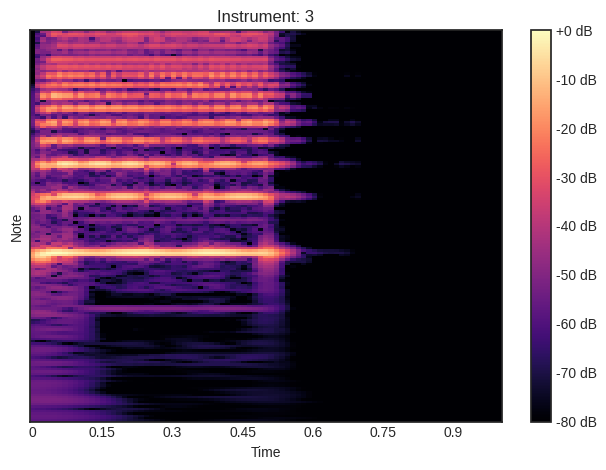

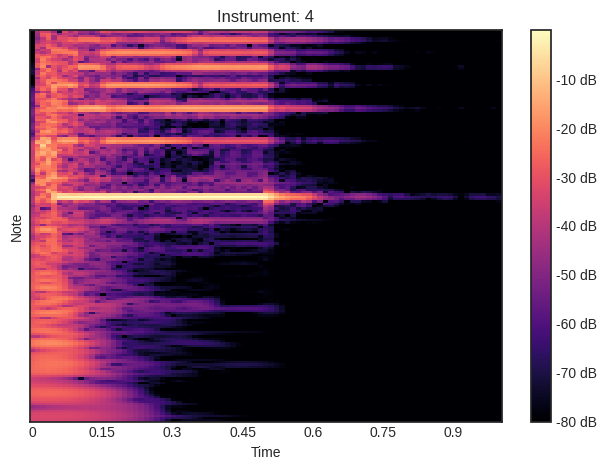

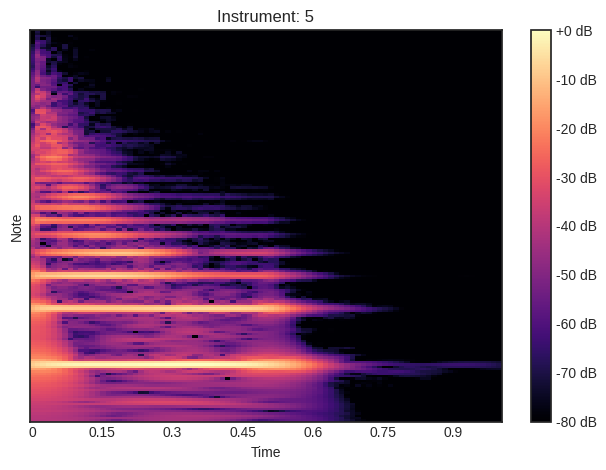

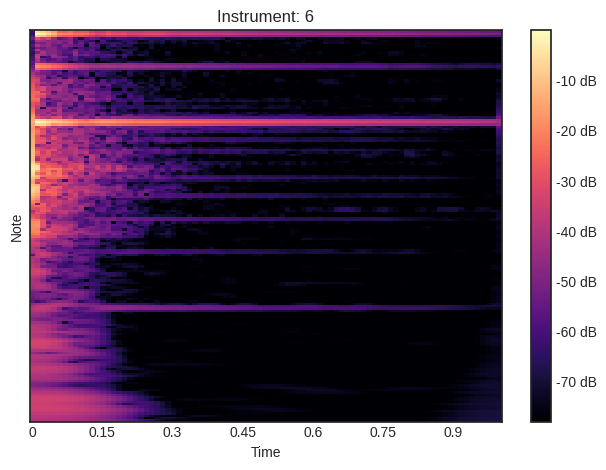

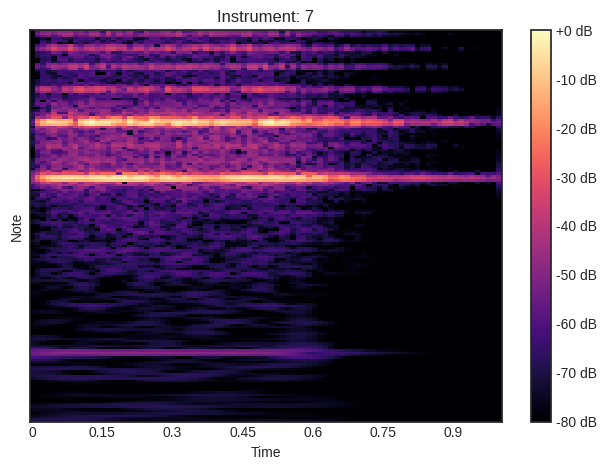

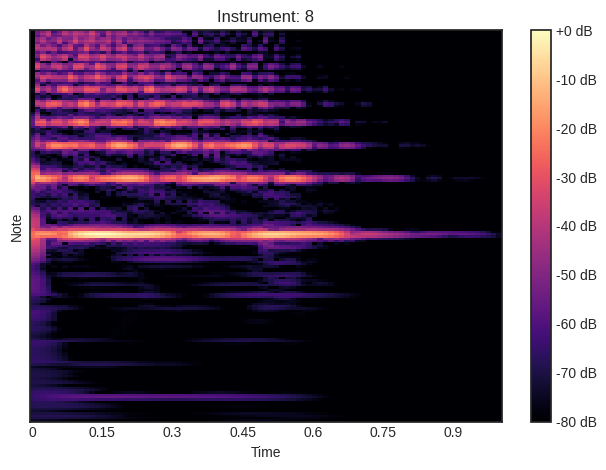

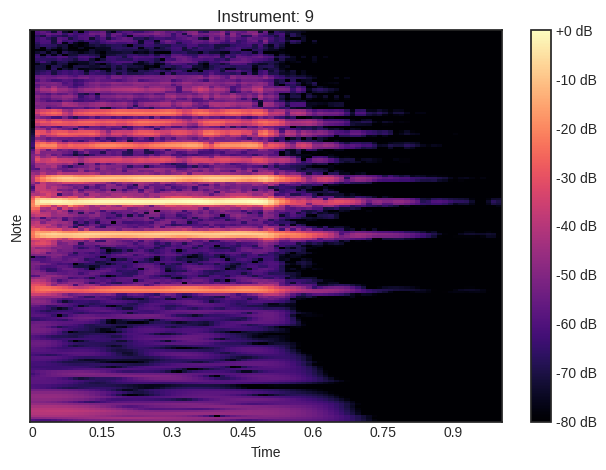

In [27]:
for i in range(0, len(instruments) * num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_cqt[i]), ref=np.max)
  librosa.display.specshow(amp_db, sr=sr, x_axis='time', y_axis='cqt_note')
  plt.colorbar(format='%+2.0f dB')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

* 훈련 데이터와 실험 데이터를 분리

In [28]:
cqt_np = np.array(audio_cqt, np.float32)
inst_np = np.array(inst, np.int16)

print(cqt_np.shape, inst_np.shape)

(500, 168, 87) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [29]:
cqt_np = cqt_np.reshape((500, 168 * 87))




*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(cqt_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [31]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(cqt_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

#데이터가 줄어듬

(400, 14616)
(100, 14616)
(400,)
(100,)


### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.24


### Support Vector Machine

In [33]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.25


### Decision Tree

In [34]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.67


## Constant-Q 특징을 이용한 딥러닝 오디오 분류

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [35]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_np = cqt_np.reshape((500, 168 * 87))
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 14616, 1)
(100, 14616, 1)
(400, 10)
(100, 10)


In [36]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(14616, ), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=input, outputs=output)
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model

In [37]:
model = model_build()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 14616)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden1 (Dense)                      │ (None, 512)                 │       7,483,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,649,418 (29.18 MB)

 Trainable params: 7,649,418 (29.18 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 856ms/step - acc: 0.1254 - loss: 2.2641 - val_acc: 0.2250 - val_loss: 2.0881
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.3465 - loss: 1.9401 - val_acc: 0.2875 - val_loss: 1.9171
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.5127 - loss: 1.6355 - val_acc: 0.2250 - val_loss: 1.8997
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.6281 - loss: 1.3297 - val_acc: 0.2500 - val_loss: 1.9634
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.7492 - loss: 1.0705 - val_acc: 0.2625 - val_loss: 2.1072
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.7797 - loss: 0.8010 - val_acc: 0.2500 - val_loss: 2.3085
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.7883 - loss: 0.6983 - val_acc: 0.2750 - val_loss: 2.5267
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.8494 - loss: 0.5807 - val_acc: 0.2875 - val_loss: 2.6701
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.9072 - loss: 0.4577 -

In [39]:
def plot_history(history_dict):
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(loss) + 1)
  fig = plt.figure(figsize=(14,5))

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, loss, 'b--', label='train_loss')
  ax1.plot(epochs, val_loss, 'r--', label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  acc = history_dict['acc']
  val_acc = history_dict['val_acc']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, acc, 'b--', label='train_accuracy')
  ax2.plot(epochs, val_acc, 'r--', label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.grid()
  ax2.legend()

  plt.show()

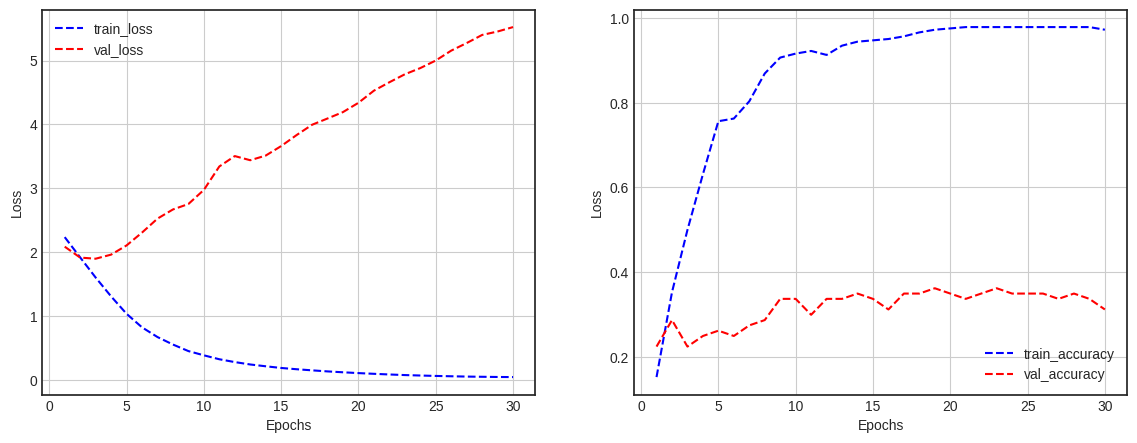

In [40]:
plot_history(history.history)

In [41]:
model.evaluate(test_x, test_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - acc: 0.3507 - loss: 6.8980


[6.993983268737793, 0.33000001311302185]

↑데이터가 작아 오버피팅 됨

### CNN 모델 구성



*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [42]:
from keras.utils import to_categorical

cqt_np = np.array(audio_cqt, np.float32)
cqt_array = np.expand_dims(cqt_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(cqt_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 168, 87, 1)
(100, 168, 87, 1)
(400, 10)
(100, 10)


In [43]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape=(168, 87, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])

  return model

In [44]:
model = model_build()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 168, 87, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 168, 87, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 84, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 84, 44, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 42, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 42, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 21, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 118272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      60,555,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,197,898 (237.27 MB)

 Trainable params: 62,197,898 (237.27 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 53s 11s/step - acc: 0.1156 - loss: 2.2699 - val_acc: 0.2875 - val_loss: 1.9010
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - acc: 0.3498 - loss: 1.7815 - val_acc: 0.2750 - val_loss: 1.7028
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - acc: 0.4563 - loss: 1.3377 - val_acc: 0.5375 - val_loss: 1.4994
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - acc: 0.6676 - loss: 0.8825 - val_acc: 0.7500 - val_loss: 0.8767
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - acc: 0.7689 - loss: 0.6822 - val_acc: 0.7000 - val_loss: 1.2429
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - acc: 0.7697 - loss: 0.6245 - val_acc: 0.8375 - val_loss: 0.8347
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - acc: 0.8496 - loss: 0.5439 - val_acc: 0.7875 - val_loss: 0.7786
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - acc: 0.8680 - loss: 0.3833 - val_acc: 0.8000 - val_loss: 0.7324
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - acc: 0.8918 - loss: 0

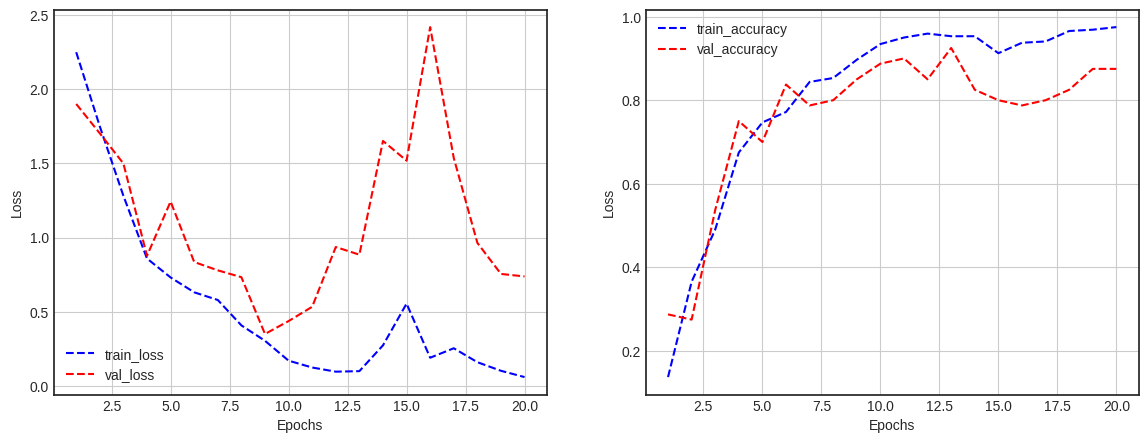

In [46]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [47]:
model.evaluate(test_x, test_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 664ms/step - acc: 0.8959 - loss: 0.3592


[0.4208485782146454, 0.8700000047683716]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [ ]:
audio_mfcc = []
for y in audio:
  ret = librosa.feature.mfcc(y=y, sr=sr)
  audio_mfcc.append(ret)

<ipython-input-94-538e9703fc2c>:6: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9839 (\N{MUSIC SHARP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


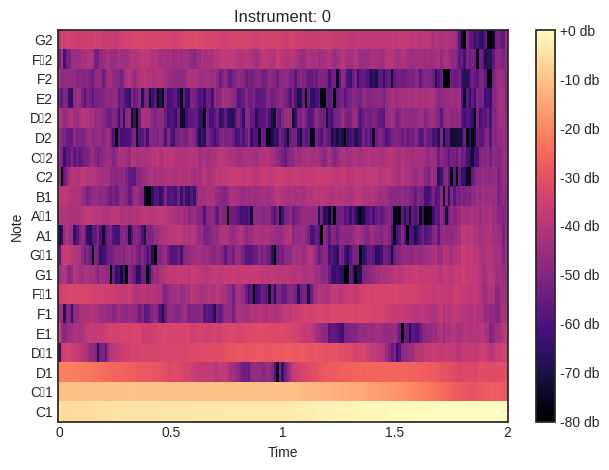

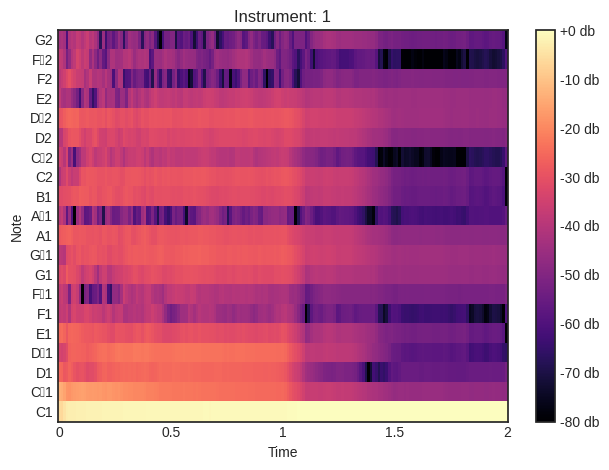

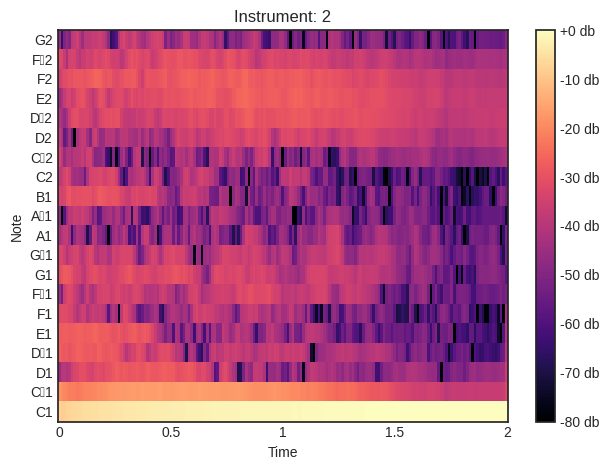

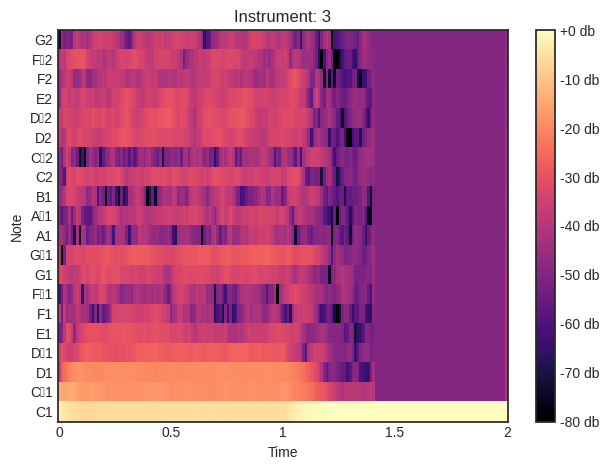

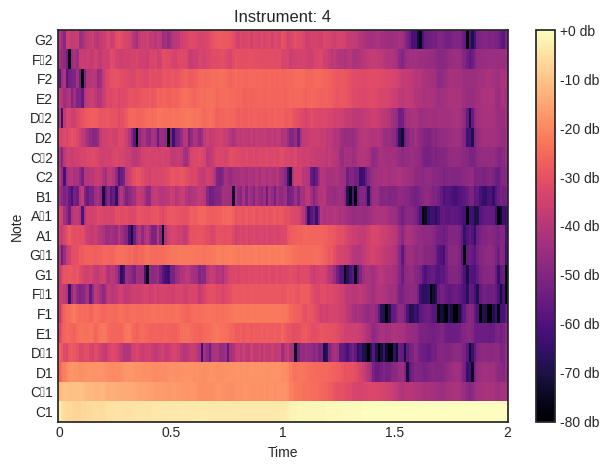

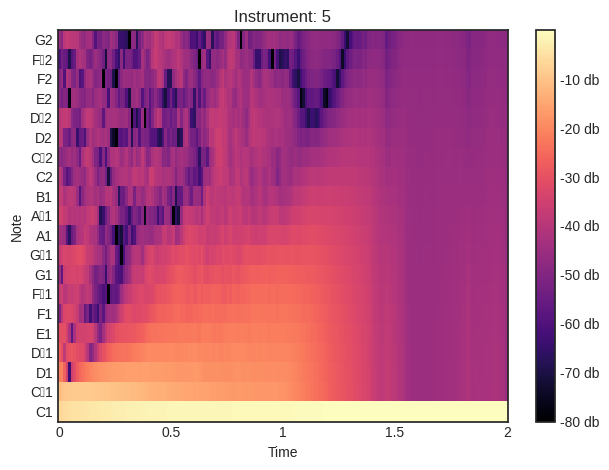

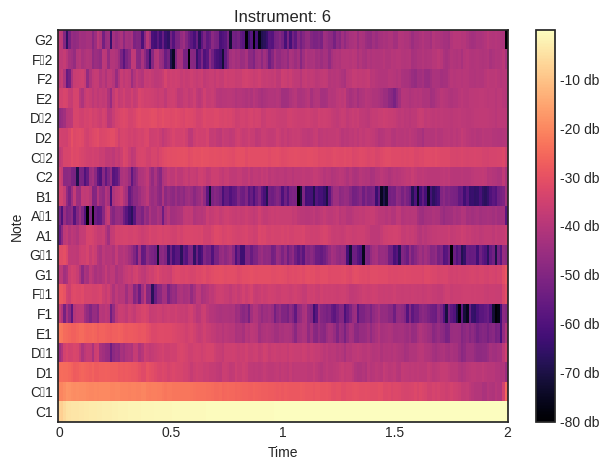

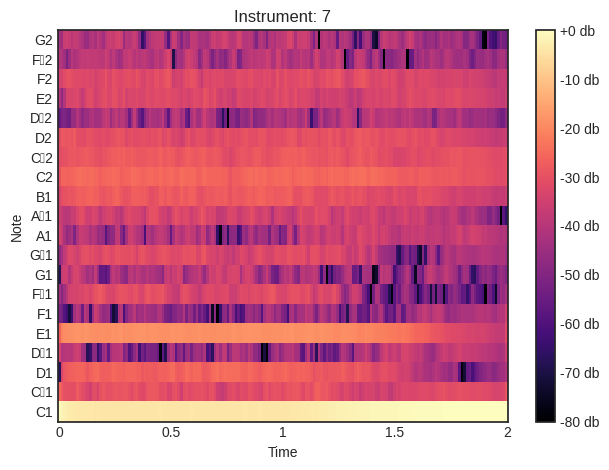

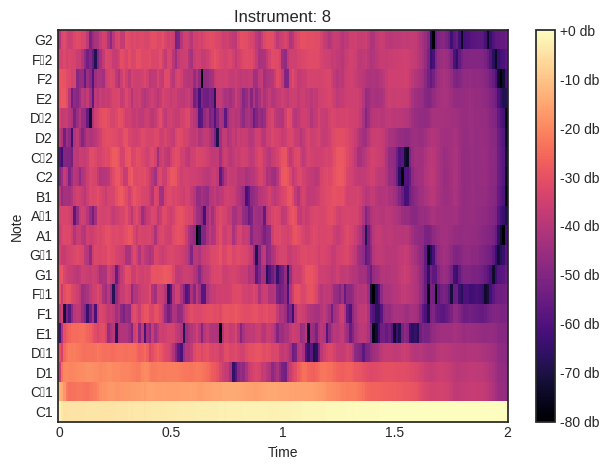

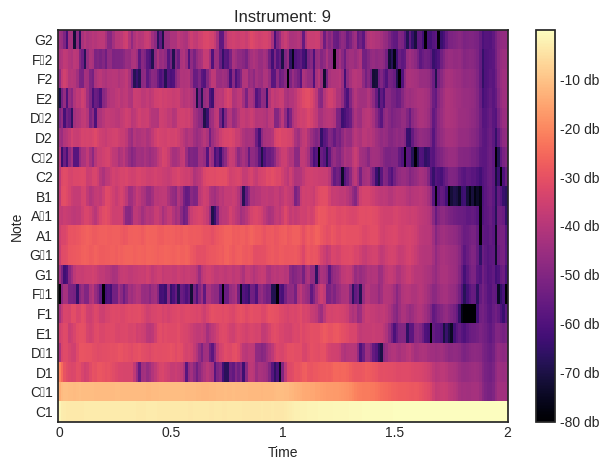

In [ ]:
for i in range(0, len(instruments)*num_notes, num_notes):
  amp_db = librosa.amplitude_to_db(np.abs(audio_mfcc[i]), ref=np.max)
  librosa.display.specshow(amp_db,sr=sr,x_axis='time',y_axis='cqt_note')
  plt.colorbar(format='%+2.0f db')
  plt.title('Instrument: {}'.format(inst[i]))
  plt.tight_layout()
  plt.show()

In [ ]:
mfcc_np = np.array(audio_mfcc, np.float32)
inst_np = np.array(inst, np.int16)

print(mfcc_np.shape, inst_np.shape)

(500, 20, 173) (500,)




*   분류기에서 사용하기 위해 3차원 벡터를 2차원 벡터로 변환



In [ ]:
mfcc_np = mfcc_np.reshape((500, 20 * 173))



*   읽어온 데이터는 음량이나 범위가 다를 수 있음
*   min-max scaling을 통해 데이터의 범위를 조정함



In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(mfcc_np)

MinMaxScaler()

* 학습 데이터와 실험 데이터를 분리

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(mfcc_np, inst_np, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3460)
(100, 3460)
(400,)
(100,)


### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
LR.fit(train_x, train_y)
pred = LR.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.97


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Support Vector Machine

In [ ]:
from sklearn import svm

SVM = svm.SVC(kernel='linear')
SVM.fit(train_x, train_y)
pred = SVM.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

0.97


### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier()
DT.fit(train_x, train_y)
pred = DT.predict(test_x)
acc = accuracy_score(pred, test_y)
print(acc)

#오디오 feature를 뭘 쓰느냐가 성능에 중요한 역할을 함

0.86


## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [ ]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_np = mfcc_np.reshape((500, 20 * 173))
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(400, 3460, 1)
(100, 3460, 1)
(400, 10)
(100, 10)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense

def model_build():
  model = Sequential()

  input = Input(shape=(3460, ), name='input')
  output = Dense(512, activation='relu', name='hidden1')(input)
  output = Dense(256, activation='relu', name='hidden2')(output)
  output = Dense(128, activation='relu', name='hidden3')(output)
  output = Dense(10, activation='softmax', name='output')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
model = model_build()
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 3460)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden1 (Dense)                      │ (None, 512)                 │       1,772,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,937,546 (7.39 MB)

 Trainable params: 1,937,546 (7.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - acc: 0.0576 - loss: 310.2206 - val_acc: 0.1125 - val_loss: 368.6386
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.1201 - loss: 290.8303 - val_acc: 0.1750 - val_loss: 199.0624
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc: 0.2395 - loss: 140.2653 - val_acc: 0.2125 - val_loss: 94.5312
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - acc: 0.2711 - loss: 61.5923 - val_acc: 0.3250 - val_loss: 43.5435
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - acc: 0.3625 - loss: 39.4675 - val_acc: 0.2875 - val_loss: 47.4762
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.3832 - loss: 38.9918 - val_acc: 0.3375 - val_loss: 42.3594
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - acc: 0.4898 - loss: 25.0873 - val_acc: 0.4125 - val_loss: 27.5000
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - acc: 0.5736 - loss: 18.6916 - val_acc: 0.5500 - val_loss: 14.0906
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - acc: 0.

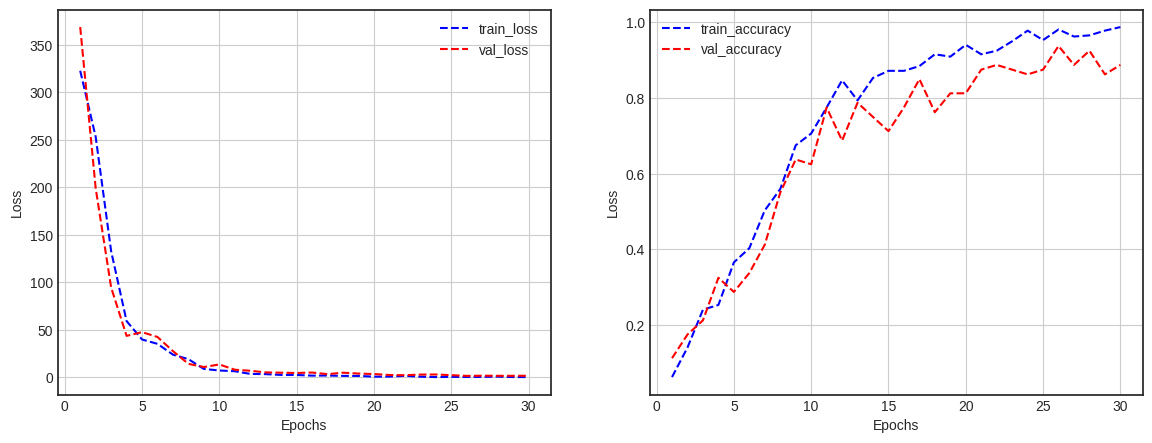

In [ ]:
plot_history(history.history)

In [ ]:
model.evaluate(test_x, test_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.8782 - loss: 1.5427


[1.9222503900527954, 0.8700000047683716]

### CNN 모델 구성

In [ ]:
from keras.utils import to_categorical

mfcc_np = np.array(audio_mfcc, np.float32)
mfcc_array = np.expand_dims(mfcc_np, -1)
inst_cat = to_categorical(inst_np)

train_x, test_x, train_y, test_y = train_test_split(mfcc_array, inst_cat, test_size=0.2)

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)


(400, 20, 173, 1)
(100, 20, 173, 1)
(400, 10)
(100, 10)




*   spectrogram을 분류할 CNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [ ]:
from keras.layers import Conv2D, MaxPool2D, Flatten

def model_build():
  model = Sequential()

  input = Input(shape=(20, 173, 1))

  output = Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
  output = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dense(256, activation='relu')(output)
  output = Dense(128, activation='relu')(output)

  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model

In [ ]:
model = model_build()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 20, 173, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 20, 173, 128)        │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 87, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 87, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 44, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 44, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 22, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 33792)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      17,302,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,944,138 (72.27 MB)

 Trainable params: 18,944,138 (72.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_x, train_y, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 9s/step - acc: 0.0883 - loss: 98.1906 - val_acc: 0.0625 - val_loss: 42.0510
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - acc: 0.1238 - loss: 29.2142 - val_acc: 0.0750 - val_loss: 2.5000
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - acc: 0.1330 - loss: 2.4954 - val_acc: 0.2375 - val_loss: 2.2564
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 40s 9s/step - acc: 0.1377 - loss: 2.3466 - val_acc: 0.1625 - val_loss: 2.2083
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 9s/step - acc: 0.2225 - loss: 2.1707 - val_acc: 0.3375 - val_loss: 1.9209
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - acc: 0.3896 - loss: 1.9558 - val_acc: 0.4250 - val_loss: 1.5597
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 9s/step - acc: 0.3590 - loss: 1.7110 - val_acc: 0.4625 - val_loss: 1.3968
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 9s/step - acc: 0.5721 - loss: 1.3733 - val_acc: 0.7500 - val_loss: 0.9766
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 29s 10s/step - acc: 0.6637 - loss: 1.0458 - val_a

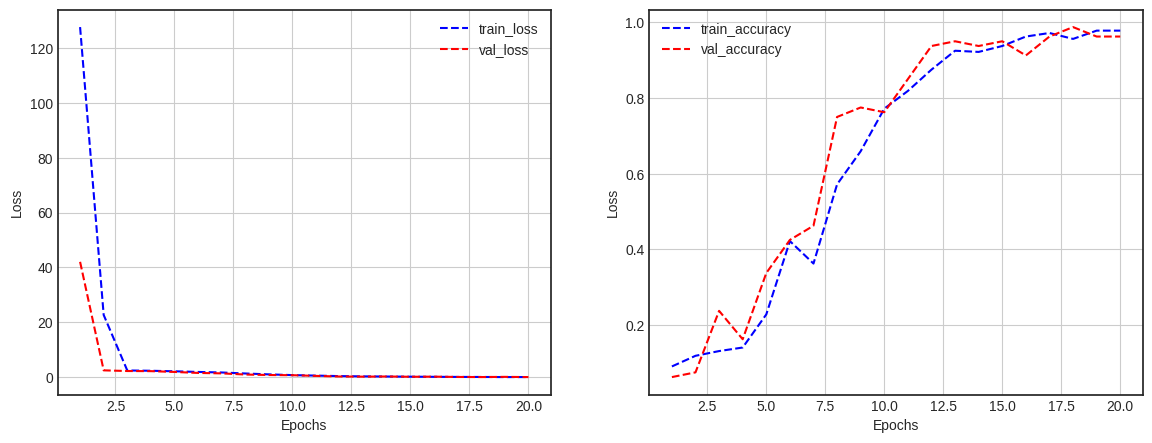

In [ ]:
plot_history(history.history)

In [ ]:
model.evaluate(test_x, test_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step - acc: 0.9745 - loss: 0.0454


[0.052881836891174316, 0.9700000286102295]